In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Stats for ray27-gcd-asap7.csv
{'count': minimum                50
time_this_iter_s       50
checkpoint_dir_name     0
dtype: int64, 'mean': minimum                43027.001480
time_this_iter_s         129.002546
checkpoint_dir_name             NaN
dtype: float64, 'median': minimum                39909.185500
time_this_iter_s         126.479249
checkpoint_dir_name             NaN
dtype: float64, 'mode': minimum                33020.88000
time_this_iter_s         114.58178
checkpoint_dir_name            NaN
Name: 0, dtype: float64, 'range': minimum                24583.330000
time_this_iter_s          46.295713
checkpoint_dir_name             NaN
dtype: float64, 'variance': minimum                6.953953e+07
time_this_iter_s       1.229625e+02
checkpoint_dir_name             NaN
dtype: float64, 'std': minimum                8339.036228
time_this_iter_s         11.088847
checkpoint_dir_name            NaN
dtype: float64}
Stats for ray28-gcd-asap7.csv
{'count': minimum             47
time

Stats for ray27-gcd-ihp-sg13g2.csv
{'count': minimum                100
time_this_iter_s       100
checkpoint_dir_name      0
dtype: int64, 'mean': minimum                267.480920
time_this_iter_s       114.854753
checkpoint_dir_name           NaN
dtype: float64, 'median': minimum                256.95930
time_this_iter_s       115.20528
checkpoint_dir_name          NaN
dtype: float64, 'mode': minimum                223.960000
time_this_iter_s        81.536851
checkpoint_dir_name           NaN
Name: 0, dtype: float64, 'range': minimum                122.959900
time_this_iter_s        67.891551
checkpoint_dir_name           NaN
dtype: float64, 'variance': minimum                974.769452
time_this_iter_s       248.276374
checkpoint_dir_name           NaN
dtype: float64, 'std': minimum                31.221298
time_this_iter_s       15.756788
checkpoint_dir_name          NaN
dtype: float64}
Stats for ray28-gcd-ihp-sg13g2.csv
{'count': minimum             99
time_this_iter_s    99
dtyp

<Figure size 640x480 with 0 Axes>

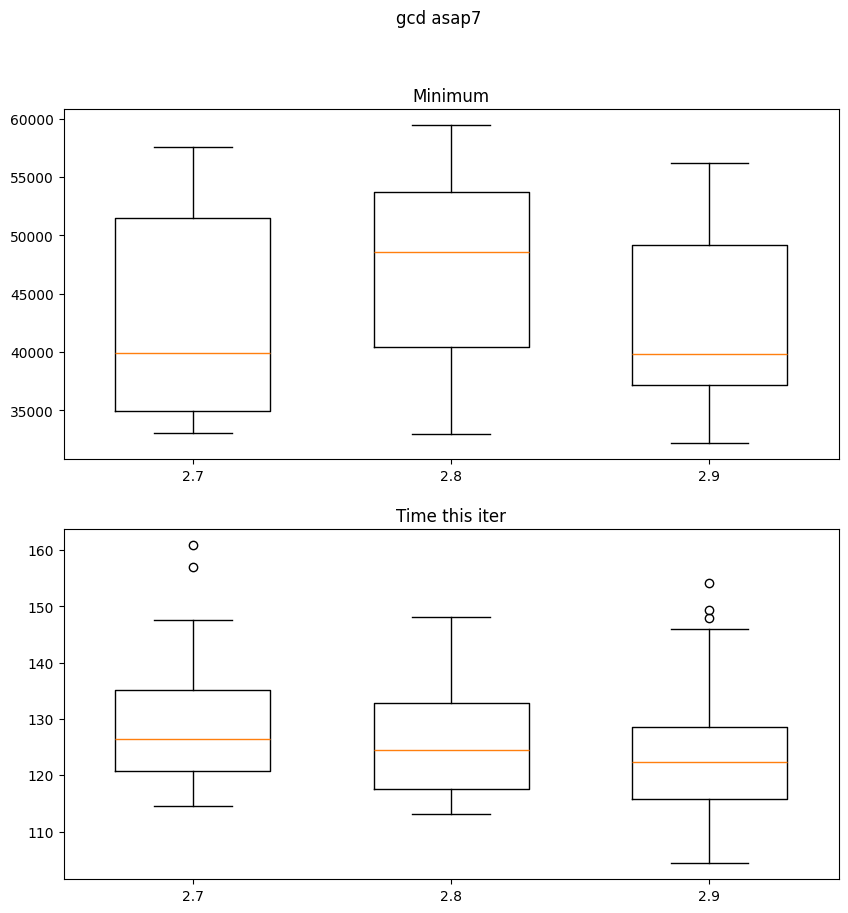

<Figure size 640x480 with 0 Axes>

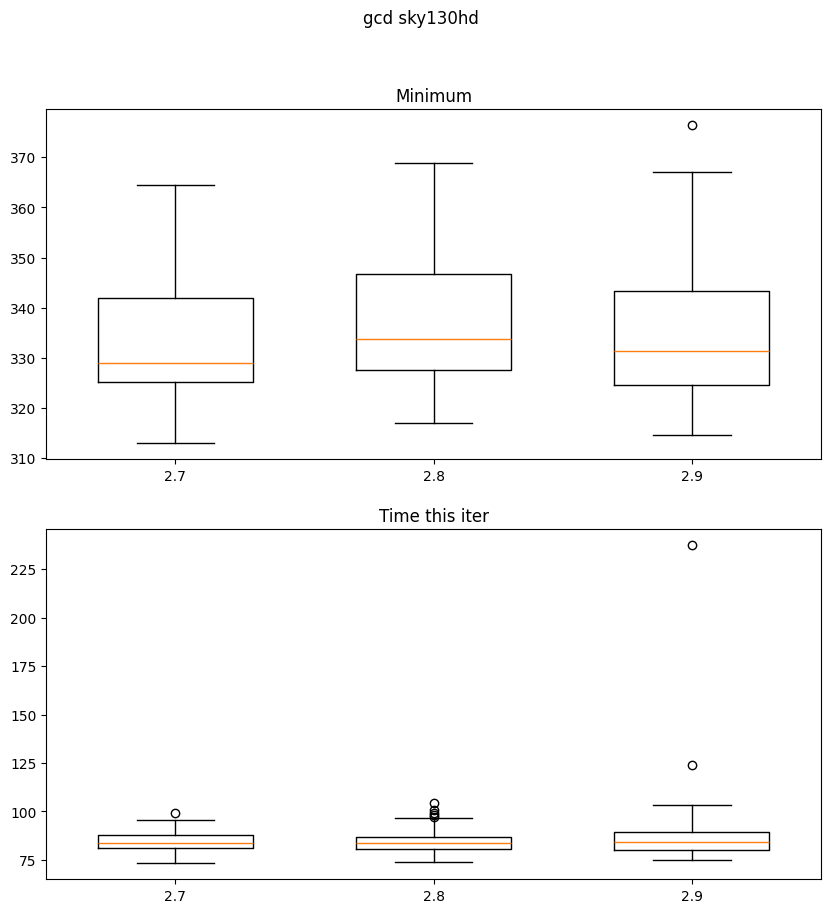

<Figure size 640x480 with 0 Axes>

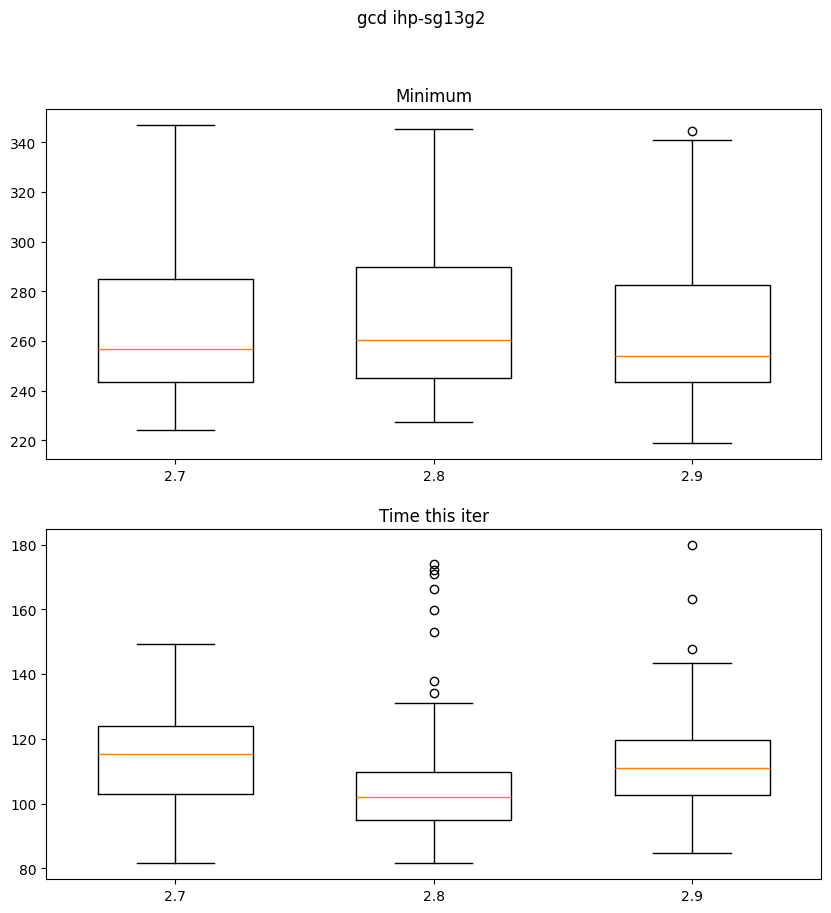

<Figure size 640x480 with 0 Axes>

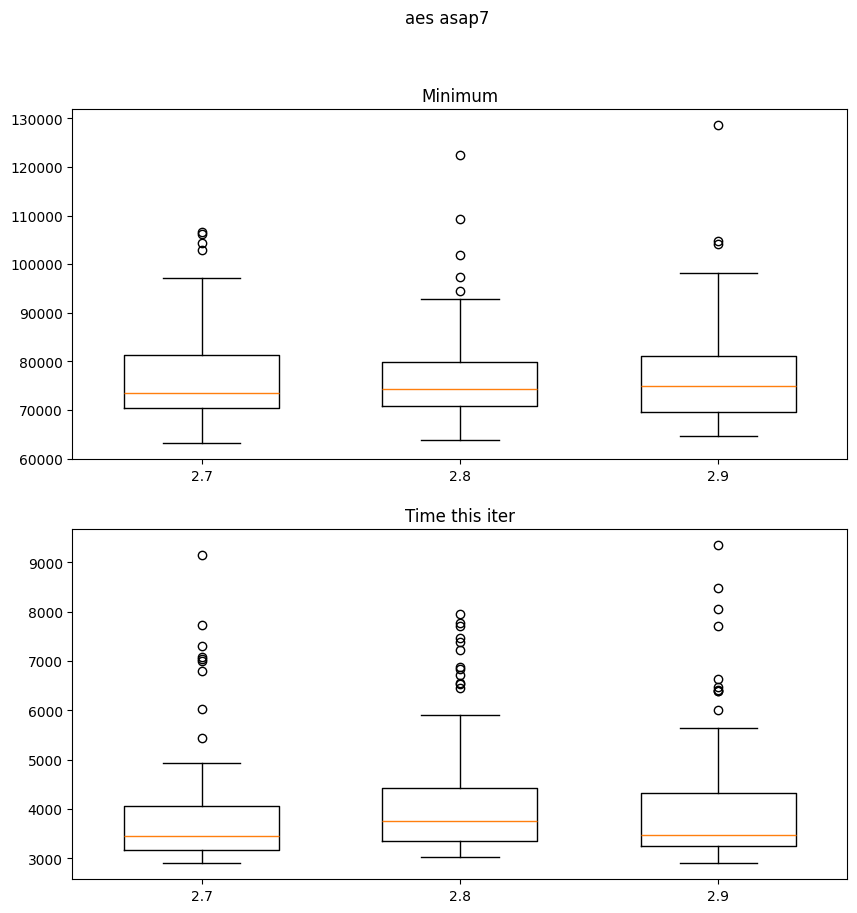

<Figure size 640x480 with 0 Axes>

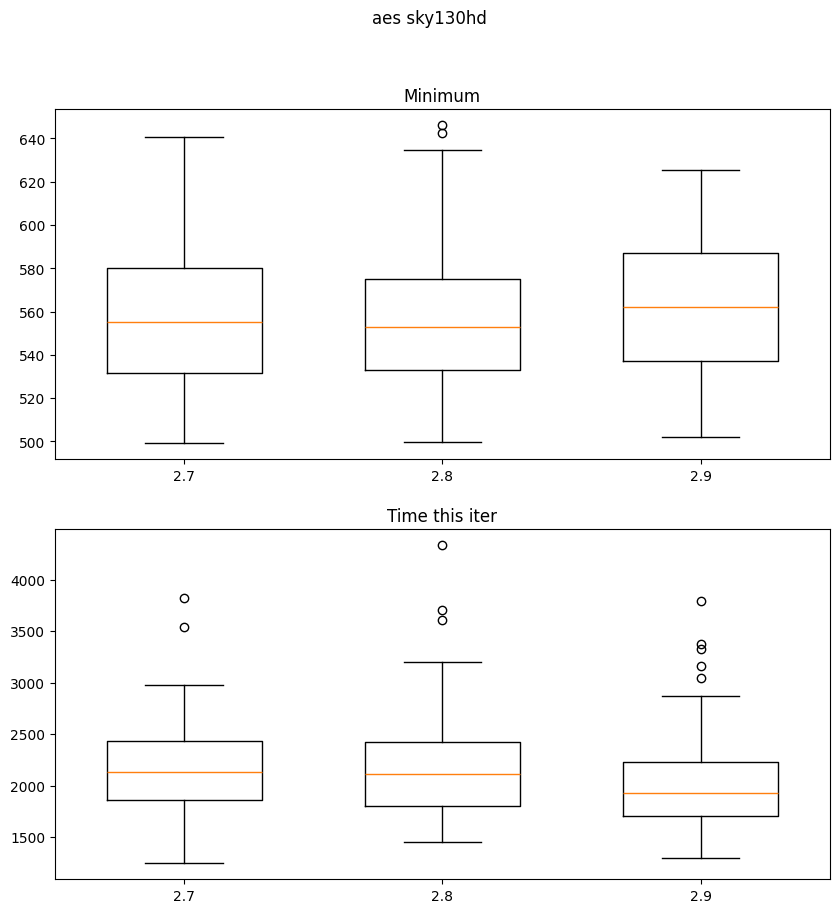

<Figure size 640x480 with 0 Axes>

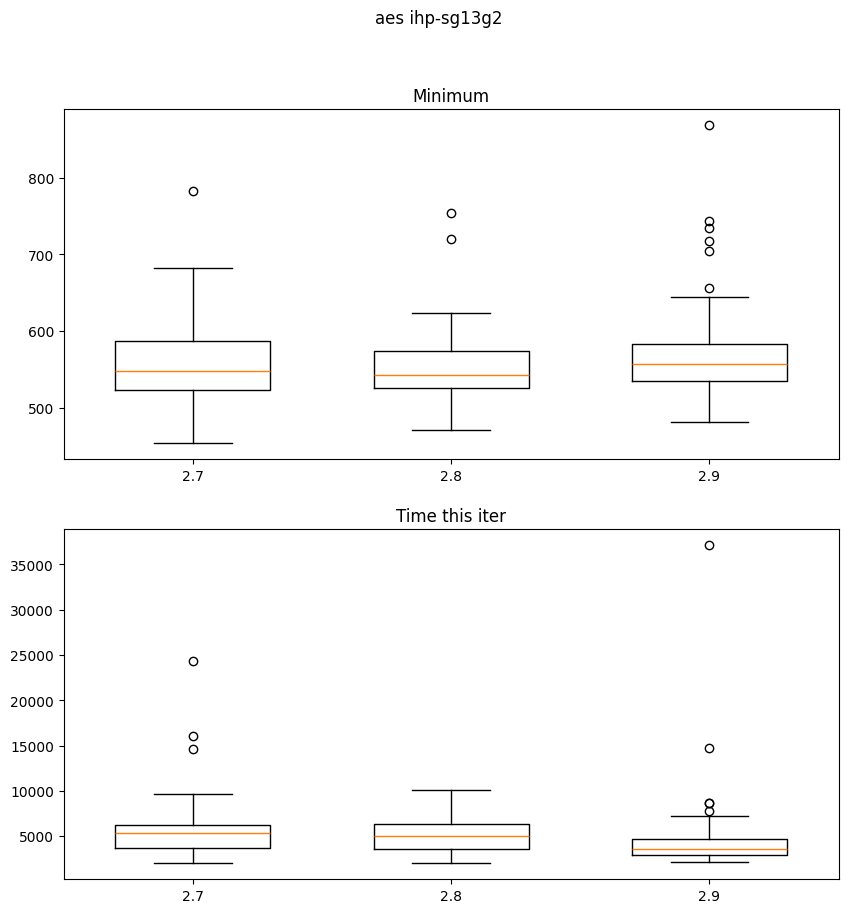

<Figure size 640x480 with 0 Axes>

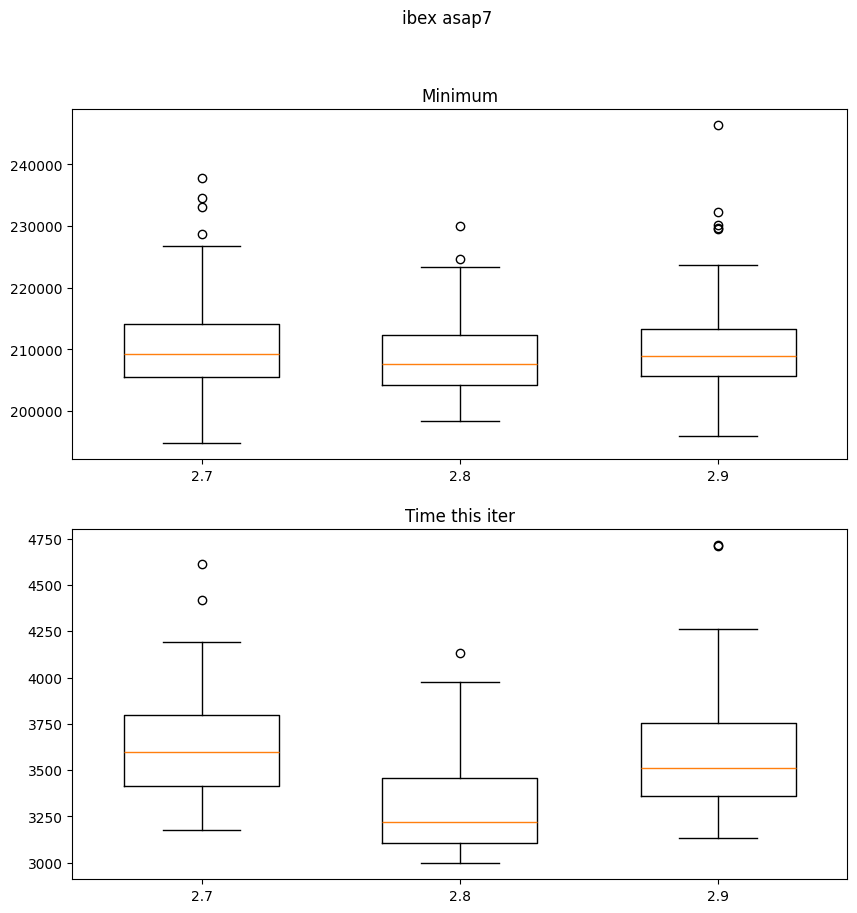

<Figure size 640x480 with 0 Axes>

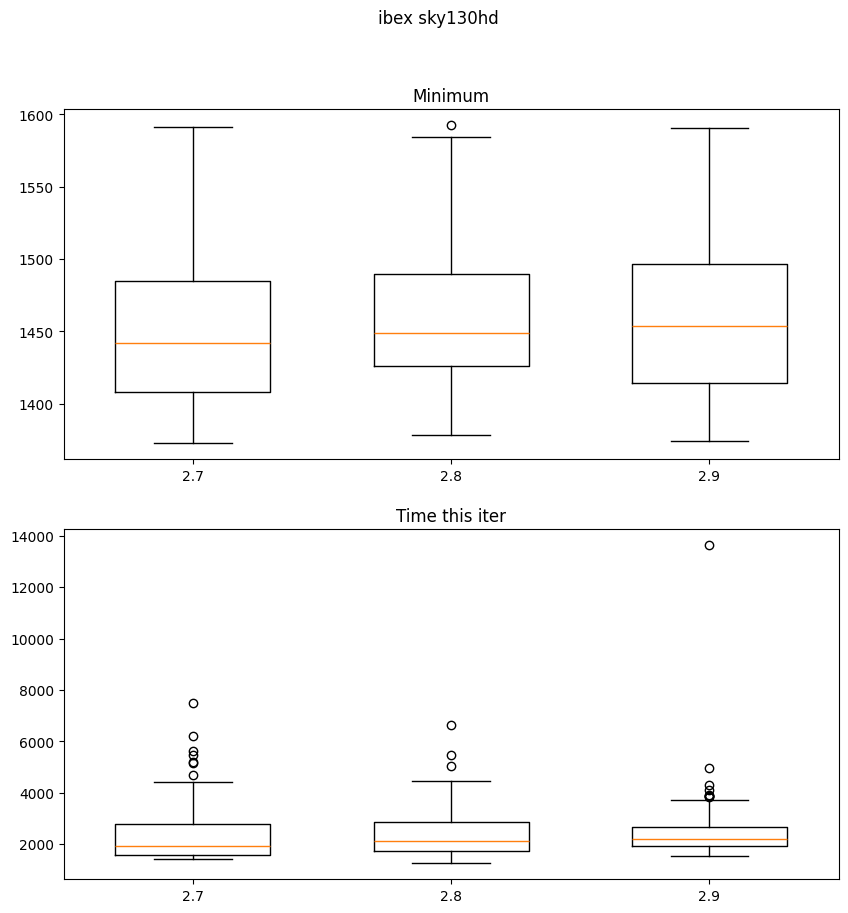

<Figure size 640x480 with 0 Axes>

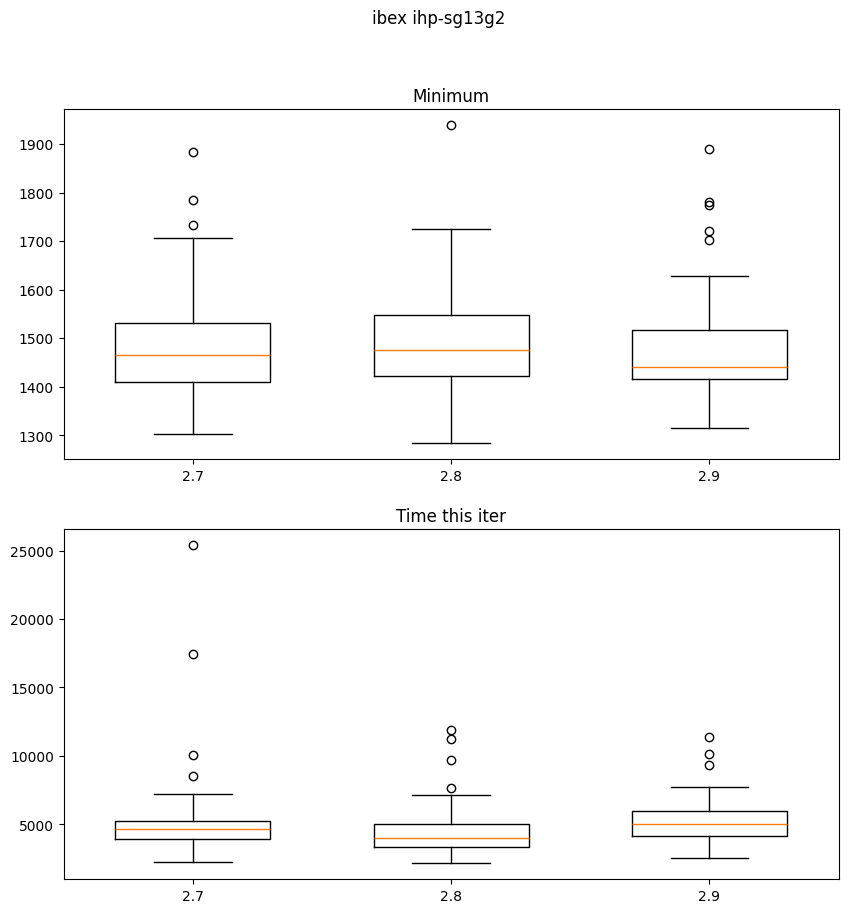

In [5]:
def load_df(filename):
    cols_to_remove = [
        "done", "training_iteration", "trial_id", "date",
        "timestamp", "pid", "hostname", "node_ip", "time_since_restore",
        "time_total_s", "iterations_since_restore"
    ]    
    return pd.read_csv(filename).drop(columns=cols_to_remove)

def calculate_stats(df):
    # first filter df to filter out the 9e99 numbers
    # count, mean, median, mode, range, variance, standard deviation
    stats = {}
    df = df[df['minimum'] != 9e99]
    stats['count'] = df.count()
    stats['mean'] = df.mean()
    stats['median'] = df.median()
    stats['mode'] = df.mode().iloc[0]
    stats['range'] = df.max() - df.min()
    stats['variance'] = df.var()
    stats['std'] = df.std()
    return stats, df

def plot(df_list, title):
    # Plot boxplot for all df, side by side with labels
    fig, ax = plt.subplots(2, figsize=(10, 10))
    for i, df in enumerate(df_list):
        ax[0].boxplot(df['minimum'], positions=[i], widths=0.6)
        ax[0].set_xticks([0, 1, 2])
        ax[0].set_xticklabels(['2.7', '2.8', '2.9'])
        ax[0].set_title('Minimum')
        ax[1].boxplot(df['time_this_iter_s'], positions=[i], widths=0.6)
        ax[1].set_xticks([0, 1, 2])
        ax[1].set_xticklabels(['2.7', '2.8', '2.9'])
        ax[1].set_title('Time this iter')

        # Set overall title
        fig.suptitle(title)
df_list = []

# Generate all the plots for the following matrix:
# ray27, ray28, ray29
# gcd, aes, ibex
# asap7, sky130hd, ihp-sg13g2
# Independent variable is the Ray version. 
# Dependent variable is the minimum and time_this_iter_s
# For each of the 3 Ray versions, we have 3 different GCDs

for design in ['gcd', 'aes', 'ibex']:
    for platform in ['asap7', 'sky130hd', 'ihp-sg13g2']:
        df_list = []
        plt.figure()
        for ray_version in ['ray27', 'ray28', 'ray29']:
            filename = f"{ray_version}-{design}-{platform}.csv"
            df = load_df(filename)
            stats, df = calculate_stats(df)
            print(f"Stats for {filename}")
            print(stats)
            df_list.append(df)
        plot(df_list, title=f"{design} {platform}")
        